In [1]:
import os, tqdm, json, pickle, gc, zipfile, itertools, time, collections
import pandas as pd
import numpy as np
from dateutil import parser
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict
from multiprocessing import Pool
import catboost as cb
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, ParameterGrid, StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance
import optuna
from optuna.samplers import TPESampler
from tqdm.contrib.concurrent import process_map  
import seaborn as sns
import matplotlib.pyplot as plt
import shap 
from sklearn.model_selection import KFold
from nancorrmp.nancorrmp import NaNCorrMp
# from pathos.multiprocessing import ProcessingPool as Pool
import multiprocessing as mp
from datetime import datetime
from optuna.samplers import TPESampler

from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation
from keras.layers import Concatenate, Reshape, SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras import regularizers

def add_profile(d_game):

    def add_global_info(d_game):

        d = {}

        d['id'] = d_game['id'] 
        d['date'] = parser.parse(d_game['begin_at'])        
        d['year'] = d['date'].year
        d['month'] = d['date'].month
        d['day'] = d['date'].day
        d['weekday'] = d['date'].weekday()
        d['hour'] = d['date'].hour
        d['number_of_games'] = d_game['match']['number_of_games']
        d['map_id'] = d_game['map']['id']
        d['league_id'] = d_game['match']['league']['id']
        d['serie_id'] = d_game['match']['serie']['id']
        d['tournament_id'] = d_game['match']['tournament']['id']
        d['serie_tier'] = d_game['match']['serie']['tier']

        return d
        
    # идентификаторы актуальных карт
    l_map2use = [1, 2, 6, 7, 8, 20, 31]
    # ключи со статистикой игрока
    l_stat_keys = ['adr', 'assists', 'deaths', 'first_kills_diff', 'flash_assists', 
                   'headshots', 'k_d_diff', 'kast', 'kills', 'rating']
    l_stat_keys_v2 = ['assists', 'deaths', 'flash_assists', 'headshots', 'kills']


    # информация об игре
    d_info = add_global_info(d_game)
    
    if d_info['map_id'] in l_map2use:  

        d_r1 = d_game['rounds'][0]
        if d_r1['round']==1:
            
            # информация о раундах
            df_rounds = pd.DataFrame.from_records(d_game['rounds'])
            start_ct_id =d_r1['ct']   
            winner_id = df_rounds['winner_team'].value_counts().idxmax()
            maxround = df_rounds['round'].max()
            d_h1_win_count = df_rounds.query('round<=15')['winner_team'].value_counts().to_dict()
            d_h2_win_count = df_rounds.query('round>15')['winner_team'].value_counts().to_dict()
            d_h1_outcome_count = df_rounds.query('round<=15')['outcome'].value_counts().to_dict()
            d_h2_outcome_count = df_rounds.query('round>15')['outcome'].value_counts().to_dict()        

            L = []
            counter = 0
            # информация об игроках
            for p in d_game['players']:
                counter+=1

                d = {}
                d.update(d_info)

                # идентификатор игрока
                d['player_id'] = p['player']['id']
                # идентификатор команды
                d['team_id'] = p['team']['id']
                # идентификатор оппонента
                d['opponent_id'] = p['opponent']['id']

                # национальность игрока
                d['player_nationality']  = p['player']['nationality']
                d['player_hometown']  = p['player']['hometown']
                # дата рождения игрока
                d['player_birthday'] = p['player']['birthday']
                # страна команды
                d['team_location']  = p['team']['location']

                # сторона начала
                d['start_ct']= 1 if start_ct_id==d['team_id'] else 0
                # победа
                d['win'] = 1 if winner_id==d['team_id'] else 0
                # все раундов в игре
                d['maxround'] = maxround

                # число выигранных раундов в 1-ой половине игры
                try:
                    d['h1_win_count'] = d_h1_win_count[d['team_id']]
                except:
                    d['h1_win_count'] = 0 
                # число выигранных раундов во 2-ой половине игры
                try:
                    d['h2_win_count'] = d_h2_win_count[d['team_id']]
                except:
                    d['h2_win_count'] = 0 
                # исходы раундов в 1-ой половине игры
                for k, v in d_h1_outcome_count.items():
                    d[f'h1_outcome_{k}_count'] = v
                # исходы раундов во 2-ой половине игры
                for k, v in d_h2_outcome_count.items():
                    d[f'h2_outcome_{k}_count'] = v            

                # статистика игрока
                d.update({k:p[k] if pd.notnull(p[k]) else 0.0 for k in l_stat_keys})
                d.update({f'{k}_per_round':p[k]/maxround if pd.notnull(p[k]) else 0.0 for k in l_stat_keys_v2})

                L.append(d)
            if counter==10:
                return L
            else:
                return None
        else:
            return None

def get_responses(PATH_TO_RESPONSES):
    L_FILENAMES = os.listdir(PATH_TO_RESPONSES)
    L_RESPONSES = []
    for fnm in tqdm.tqdm(L_FILENAMES):
        try:
            pth = os.path.join(PATH_TO_RESPONSES, fnm)
            with open(pth, 'r') as f:
                d_rsp = json.load(f)
            L_RESPONSES.append(d_rsp)
        except:
            pass
    idx_ordered = np.argsort([d_game['id'] for d_game in L_RESPONSES])[::-1]
    L_RESPONSES = np.array(L_RESPONSES)[idx_ordered].tolist()
    return L_RESPONSES

def scale(x, out_range=(-1, 1)):
    domain = np.min(x), np.max(x)
    y = (x - (domain[1] + domain[0]) / 2) / (domain[1] - domain[0])
    return y * (out_range[1] - out_range[0]) + (out_range[1] + out_range[0]) / 2

### респонсы

In [2]:
PATH_TO_RESPONSES = 'L_games_collection'

# респонсы
L_RESPONSES = get_responses(PATH_TO_RESPONSES)

100%|██████████| 57985/57985 [00:20<00:00, 2838.38it/s]


### таргеты

In [9]:
def get_targets(L_RESPONSES):

    """
    Описание:
        команда1 - всегда начинает за кт: team1 = start_ct
        команда2 - всегда начинает за т: team2 = start_t
        извлекает целевые переменные для игр
            1. победитель (+при условии победы/поряжения в 1,2 раундах)
            2. тотал ранудов (м/б)
            3. тотал побед (м/б) в 1/2 половинах игры
            4. тотал побед (м/б) во 2-ой половине при условии тотал побед (м/б) в 1-ой половине
    """

    df_targets = pd.DataFrame()
    for d_rsp in tqdm.tqdm(L_RESPONSES):  

        try:
            
            game_id = d_rsp['id']
            
            ###########################################################################    
            df_rounds = pd.DataFrame.from_records(d_rsp['rounds'])

            maxround = df_rounds['round'].max()
            start_ct_id = df_rounds.query('round==1')['ct'].iloc[0]
            start_t_id = df_rounds.query('round==1')['terrorists'].iloc[0]
            df_h1 = df_rounds.query('round<=15')
            df_h2 = df_rounds.query('round>15')
            d_h1_win_count = df_h1['winner_team'].value_counts().to_dict()
            d_h2_win_count = df_h2['winner_team'].value_counts().to_dict()
            d_h1h2_win_count = df_rounds['winner_team'].value_counts().to_dict()
            winner_id = df_rounds['winner_team'].value_counts().idxmax() 
            r1_winner_id = df_rounds.query('round==1')['winner_team'].iloc[0]
            r2_winner_id = df_rounds.query('round==1')['winner_team'].iloc[0]
            r16_winner_id = df_rounds.query('round==1')['winner_team'].iloc[0]
            r17_winner_id = df_rounds.query('round==1')['winner_team'].iloc[0]
            #############################################################################
            

            d_targets4game = {'id':game_id}
            
            d_targets4game['team1__win'] = int(winner_id==start_ct_id)
            d_targets4game['team1__win|(r1_team1_win)&(r2_team1_win)'] = int((winner_id==start_ct_id)&((r1_winner_id==start_ct_id)&(r2_winner_id==start_ct_id)))
            d_targets4game['team1__win|(r1_team1_win)&(~r2_team1_win)'] = int((winner_id==start_ct_id)&((r1_winner_id==start_ct_id)&(r2_winner_id!=start_ct_id)))
            d_targets4game['team1__win|(~r1_team1_win)&(r2_team1_win)'] = int((winner_id==start_ct_id)&((r1_winner_id!=start_ct_id)&(r2_winner_id==start_ct_id)))
            d_targets4game['team1__win|(~r1_team1_win)&(~r2_team1_win)'] = int((winner_id==start_ct_id)&((r1_winner_id!=start_ct_id)&(r2_winner_id!=start_ct_id)))  

            d_targets4game['team2__win'] = int(winner_id==start_t_id)
            d_targets4game['team2__win|(r1_team2_win)&(r2_team2_win)'] = int((winner_id==start_t_id)&((r1_winner_id==start_t_id)&(r2_winner_id==start_t_id)))
            d_targets4game['team2__win|(r1_team2_win)&(~r2_team2_win)'] = int((winner_id==start_t_id)&((r1_winner_id==start_t_id)&(r2_winner_id!=start_t_id)))
            d_targets4game['team2__win|(~r1_team2_win)&(r2_team2_win)'] = int((winner_id==start_t_id)&((r1_winner_id!=start_t_id)&(r2_winner_id==start_t_id)))
            d_targets4game['team2__win|(~r1_team2_win)&(~r2_team2_win)'] = int((winner_id==start_t_id)&((r1_winner_id!=start_t_id)&(r2_winner_id!=start_t_id)))  

            for i in range(16, 31):

                d_targets4game[f'total__b__{i}'] = int(maxround>=i)
                d_targets4game[f'total__m__{i}'] = int(maxround<=i)

            for i in range(1, 16):

                d_targets4game[f'h1__team1__win__b__{i}'] = int(d_h1_win_count[start_ct_id]>=i)
                d_targets4game[f'h1__team1__win__m__{i}'] = int(d_h1_win_count[start_ct_id]<=i)    
                d_targets4game[f'h1__team2__win__b__{i}'] = int(d_h1_win_count[start_t_id]>=i)
                d_targets4game[f'h1__team2__win__m__{i}'] = int(d_h1_win_count[start_t_id]<=i)

                d_targets4game[f'h2__team1__b__{i}'] = int(d_h2_win_count[start_ct_id]>=i)
                d_targets4game[f'h2__team1__win__m__{i}'] = int(d_h2_win_count[start_ct_id]<=i)    
                d_targets4game[f'h2__team2__win__b__{i}'] = int(d_h1_win_count[start_t_id]>=i)
                d_targets4game[f'h2__team2__win__m__{i}'] = int(d_h1_win_count[start_t_id]<=i)            

                for j in range(1, 16):

                    d_targets4game[f'h2__team1__win__b__{j}|h1__team1__win__b__{i}'] = int((d_h1_win_count[start_ct_id]>=i)&((d_h2_win_count[start_ct_id]>=i)))
                    d_targets4game[f'h2__team1__win__m__{j}|h1__team1__win__b__{i}'] = int((d_h1_win_count[start_ct_id]>=i)&((d_h2_win_count[start_ct_id]<=i)))
                    d_targets4game[f'h2__team1__win__b__{j}|h1__team1__win__m__{i}'] = int((d_h1_win_count[start_ct_id]<=i)&((d_h2_win_count[start_ct_id]>=i)))
                    d_targets4game[f'h2__team1__win__m__{j}|h1__team1__win__m__{i}'] = int((d_h1_win_count[start_ct_id]<=i)&((d_h2_win_count[start_ct_id]<=i)))

                    d_targets4game[f'h2__team2__win__b__{j}|h1__team2__win__b__{i}'] = int((d_h1_win_count[start_t_id]>=i)&((d_h2_win_count[start_t_id]>=i)))
                    d_targets4game[f'h2__team2__win__m__{j}|h1__team2__win__b__{i}'] = int((d_h1_win_count[start_t_id]>=i)&((d_h2_win_count[start_t_id]<=i)))
                    d_targets4game[f'h2__team2__win__b__{j}|h1__team2__win__m__{i}'] = int((d_h1_win_count[start_t_id]<=i)&((d_h2_win_count[start_t_id]>=i)))
                    d_targets4game[f'h2__team2__win__m__{j}|h1__team2__win__m__{i}'] = int((d_h1_win_count[start_t_id]<=i)&((d_h2_win_count[start_t_id]<=i)))

            df_targets = df_targets.append(d_targets4game, ignore_index = True)
            
        except:
            pass
        
    return df_targets 

In [4]:
df_targets = get_targets(L_RESPONSES)

100%|██████████| 57984/57984 [1:04:00<00:00, 15.10it/s]


In [5]:
df_targets = df_targets.astype(int)

In [7]:
df_targets.to_pickle('df_targets.pickle')

In [6]:
df_targets.head()

,id,team1__win,team1__win|(r1_team1_win)&(r2_team1_win),team1__win|(r1_team1_win)&(~r2_team1_win),team1__win|(~r1_team1_win)&(r2_team1_win),team1__win|(~r1_team1_win)&(~r2_team1_win),total__b__16,total__m__16,total__b__17,total__m__17,...,h2__team2__win__b__14|h1__team2__win__m__15,h2__team2__win__m__14|h1__team2__win__m__15,h2__team1__win__b__15|h1__team1__win__b__15,h2__team1__win__m__15|h1__team1__win__b__15,h2__team1__win__b__15|h1__team1__win__m__15,h2__team1__win__m__15|h1__team1__win__m__15,h2__team2__win__b__15|h1__team2__win__b__15,h2__team2__win__m__15|h1__team2__win__b__15,h2__team2__win__b__15|h1__team2__win__m__15,h2__team2__win__m__15|h1__team2__win__m__15
0,72414,1,0,0,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,0,1
1,72396,0,0,0,0,0,1,0,1,0,...,0,1,0,0,0,1,0,0,0,1
2,72395,1,0,0,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,0,1
3,72380,0,0,0,0,0,1,0,1,0,...,0,1,0,0,0,1,0,0,0,1
4,72379,0,0,0,0,0,1,0,1,0,...,0,1,0,0,0,1,0,0,0,1


In [8]:
print('Количество целевых переменных: {}'.format(df_targets.shape[1]))

Количество целевых переменных: 1956


### фичи
1. таблица с профайлингом игроков в играх
2. предварительная обработка:   
    
    2.1. для каждой игры:   

        2.1.1. в команде должны играть 10 игрков           
        2.1.2. команд должно быть 2   
        2.1.3. таймаут появлялся в 70% игр        

2. таблица с фичами (рассматриваем последние 10 игр):
        
    1.1. стата команды          
    1.2. стата игрока                      
    1.3. стата игрока в команде               
    1.3. стата игрока в других командах   

In [3]:
# профайлинг игроков в играх
L_profile = []
for d_rsp in tqdm.tqdm(L_RESPONSES):
    try:
        L_profile.extend(add_profile(d_rsp))
    except:
        pass
df_profile = pd.DataFrame.from_records(L_profile)
df_profile['timestamp'] = df_profile['date'].apply(lambda x:x.timestamp())
df_profile['player_birthday_year'] = df_profile['player_birthday'].astype('datetime64').dt.year
df_profile['player_age'] = df_profile['year'] - df_profile['player_birthday_year']
del L_profile
gc.collect()
df_profile.drop(['player_birthday','player_birthday_year'], 1, inplace = True)

100%|██████████| 57984/57984 [04:18<00:00, 224.23it/s]


In [4]:
ser_nunique_players4game = df_profile.groupby('id')['player_id'].nunique()
ser_nunique_teams4game = df_profile.groupby('id')['team_id'].nunique()
df_profile_c = df_profile[
    (df_profile['id'].isin(ser_nunique_players4game[ser_nunique_players4game==10].index))&\
    (df_profile['id'].isin(ser_nunique_teams4game[ser_nunique_teams4game==2].index))
    ]\
    .sort_values('date').reset_index(drop = True)

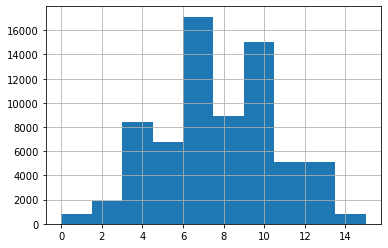

In [5]:
df_profile_c.groupby(['id', 'team_id'])['h1_win_count'].mean().hist();

In [6]:
del df_profile
df_profile = df_profile_c.copy()
del df_profile_c
gc.collect()

3720

In [7]:
ser_nan_rate = df_profile.isna().mean()

In [8]:
ser_nan_rate[ser_nan_rate>0].sort_values(ascending = False)

h2_outcome_timeout_count       0.732294
h1_outcome_timeout_count       0.636226
player_hometown                0.281058
h2_outcome_defused_count       0.280629
h2_outcome_exploded_count      0.244946
serie_tier                     0.209292
team_location                  0.189693
h1_outcome_defused_count       0.154882
player_age                     0.137224
h1_outcome_exploded_count      0.095154
player_nationality             0.004106
h2_outcome_eliminated_count    0.001573
dtype: float64

In [9]:
df_profile['h1_outcome_timeout_any'] = (df_profile['h1_outcome_timeout_count'].notna()).astype(int)
df_profile['h2_outcome_timeout_any'] = (df_profile['h2_outcome_timeout_count'].notna()).astype(int)

In [10]:
def get_features4last_n_games(df_profile, L_GAME_IDXS, LAST_N_GAMES):

    """
    Извлекает признаки для последних игр игроков и команд  
    Параметры:
        1. df_profile - профайлинг игроков и команд в играх
        2. LAST_N_GAMES - кол-во послених игр для использования   
    """

    L_rows = []
    for game_id in tqdm.tqdm(L_GAME_IDXS):

        try:

            # игра
            df_game = df_profile.query('id==@game_id')
            
            # словарь с командами и их строной начала в игре
            d_team_id2start_ct = dict(zip(df_game['team_id'], df_game['start_ct']))
            # словарь с игроками и командой в игре
            d_player_d2team_id = dict(zip(df_game['player_id'], df_game['team_id']))
            # таблица с идентификаторами команд, игроков, странами, национальностями и родными городами
            df_player_with_team_info = df_game[L_PLAER_TEAM_INFO_KEYS]

            # дата игры 
            date = df_game['date'].iloc[0]

            d_fs4gm = df_game[L_INFO_KEYS].iloc[0].to_dict()

            for team_id, start_ct in d_team_id2start_ct.items():
                    
                # префикс для признаков команд
                prefix_team = f'team1' if start_ct==1 else 'team2'         
                # игроки для команды
                L_p_id4team = df_game.query('team_id==@team_id')['player_id'].sort_values().tolist()     
                # префикс для признаковигроков    
                L_prefix_player = d_p4t_keys[prefix_team]
                
                # информация о команде в текущей игре
                d_fs4gm[f'{prefix_team}__id'] = team_id
                d_fs4gm[f'{prefix_team}__location'] = df_player_with_team_info.loc[df_player_with_team_info['team_id']==team_id]['team_location'].iloc[0]

                # информация об игроках в текущей игре
                for player_prefix, player_id in zip(L_prefix_player, L_p_id4team):
                    d_fs4gm[f'{player_prefix}__id'] = player_id
                    for key in ['player_age', 'player_nationality', 'player_hometown']:
                        new_key = key.split('_')[-1]
                        value = df_player_with_team_info.loc[df_player_with_team_info['player_id']==player_id][key].iloc[0]
                        d_fs4gm[f'{player_prefix}__{new_key}'] = value

                # признаки: последние 10 игр команд
                df_history4team = df_profile.query('(date<@date)&(team_id==@team_id)').sort_values('date', ascending = False).head(LAST_N_GAMES)
                for j in range(len(df_history4team)):
                    row = df_history4team.iloc[j]
                    d = df_profile.loc[df_profile['id'] == row['id'], ['timestamp', 'map_id', 'number_of_games', 'serie_tier']]\
                                .add_prefix(f'{prefix_team}__last{j+1}__').iloc[0].to_dict()
                    for k in L_TEAM_KEYS:
                        d[f'{prefix_team}__last{j+1}__{k}'] = row[k]
                    d_fs4gm.update(d)
                    del d

                # признаки: последние 10 игр игроков
                for player_prefix, player_id in zip(L_prefix_player, L_p_id4team):
                    df_history4player = df_profile.query('(date<@date)&(player_id==@player_id)').sort_values('date', ascending = False).head(LAST_N_GAMES)
                    for j in range(len(df_history4player)):
                        row = df_history4player.iloc[j]
                        d = df_profile.loc[df_profile['id'] == row['id'], ['timestamp', 'map_id', 'number_of_games', 'serie_tier']]\
                                    .add_prefix(f'{player_prefix}__last{j+1}__').iloc[0].to_dict()
                        for k in L_PLAYER_KEYS:
                            d[f'{player_prefix}__last{j+1}__{k}'] = row[k]
                        d_fs4gm.update(d)
                        del d
            L_rows.append(d_fs4gm)
            del d_fs4gm
        except:
            pass

    df = pd.DataFrame.from_records(L_rows)
    del L_rows
    gc.collect()

    return df   

# информация об игре
L_INFO_KEYS = [
    'id', 'date', 'timestamp',
    'year','month', 'day', 'weekday', 'hour',
    'number_of_games', 'map_id', 'serie_tier']

# игроки и команды с инфой
L_PLAER_TEAM_INFO_KEYS = ['player_id', 'team_id', 'player_age', 'player_nationality', 'player_hometown', 'team_location']

# стата команд
L_TEAM_KEYS = [
    'start_ct', 'win',
    'maxround', 'h1_win_count', 'h2_win_count',
    'h1_outcome_eliminated_count', 'h1_outcome_exploded_count',
    'h1_outcome_defused_count', 'h2_outcome_eliminated_count',
    'h2_outcome_exploded_count', 'h2_outcome_defused_count',
    'h1_outcome_timeout_count', 'h2_outcome_timeout_count',
    'h1_outcome_timeout_any', 'h2_outcome_timeout_any'
]

# стата игроков
L_PLAYER_KEYS = [
    'adr',
    'assists', 'deaths', 'first_kills_diff', 'flash_assists', 'headshots',
    'k_d_diff', 'kast', 'kills', 'rating', 'assists_per_round',
    'deaths_per_round', 'flash_assists_per_round', 'headshots_per_round',
    'kills_per_round'
]

# словарь с префиксами игркоов для команд
d_p4t_keys = {'team1':['player1', 'player2', 'player3', 'player4', 'player5'],
              'team2':['player6', 'player7', 'player8', 'player9', 'player10']}

# число последних игр для учета в признаках
LAST_N_GAMES = 10

# все игры
L_GAME_IDXS=np.unique(df_profile['id'])

In [11]:
df_features_last_100 = get_features4last_n_games(df_profile, L_GAME_IDXS[-100:], LAST_N_GAMES)

100%|██████████| 100/100 [00:28<00:00,  3.55it/s]


In [13]:
df_features_last_100.to_pickle('df_features_last_100.pickle')

In [14]:
df_features_last_100.head()

,id,date,timestamp,year,month,day,weekday,hour,number_of_games,map_id,...,player10__last10__headshots,player10__last10__k_d_diff,player10__last10__kast,player10__last10__kills,player10__last10__rating,player10__last10__assists_per_round,player10__last10__deaths_per_round,player10__last10__flash_assists_per_round,player10__last10__headshots_per_round,player10__last10__kills_per_round
0,71945,2022-05-06 18:40:52+00:00,1.651862e+09,2022,5,6,4,18,3,6,...,8.0,-8.0,56.0,12.0,0.74,0.080000,0.800000,0.000000,0.320000,0.480000
1,71946,2022-05-06 19:35:15+00:00,1.651866e+09,2022,5,6,4,19,3,7,...,13.0,3.0,72.5,30.0,1.26,0.250000,0.675000,0.075000,0.325000,0.750000
2,71947,2022-05-07 14:03:30+00:00,1.651932e+09,2022,5,7,5,14,3,31,...,5.0,-5.0,60.0,17.0,0.75,0.114286,0.628571,0.057143,0.142857,0.485714
3,71948,2022-05-07 15:12:40+00:00,1.651936e+09,2022,5,7,5,15,3,6,...,13.0,3.0,76.9,20.0,1.32,0.461538,0.653846,0.192308,0.500000,0.769231
4,71950,2022-05-07 17:30:10+00:00,1.651945e+09,2022,5,7,5,17,3,6,...,4.0,-2.0,76.9,18.0,1.02,0.038462,0.769231,0.000000,0.153846,0.692308
